In [1]:
import pickle
from Visualizations import RoutingV
from SD_IB_IRP_PPenv import steroid_IRP
from InstanceGenerator import instance_generator

import pandas as pd
from math import radians, sin, cos, sqrt, atan2

import folium
import requests
import json

file = open('routing_performance', 'rb')
routing_performance = pickle.load(file)
file.close()

In [2]:
########################################## Instance generator ##########################################
# SD-IB-IRP-PP model's parameters
T = 7
M = 22
K = 20
F = 6

demand_type = 'aggregated'

# Vehicles
Q = 400

# Q = 600
d_max = 4000

# Stochasticity
stochastic_params = ['d','q']
look_ahead = ['d','q']  
S = 6
LA_horizon = 3

# Historical data
historical_data = ['*']
hist_window = 100


# Other parameters
backorders = 'backorders'
back_o_cost = 10000

env_config = {'M':M, 'K':K, 'T':T, 'F':F, 'Q':Q, 
              'S':S, 'LA_horizon':LA_horizon,
             'd_max':d_max, 'hist_window':hist_window,
             'back_o_cost':back_o_cost} 

######################################### CundiBoy Instance ##########################################
### CundiBoy Instance
# Random seeds
det_rd_seed = 2                                          

# Random Instance
q_params = {'dist': 'c_uniform', 'r_f_params': 10}          # Offer
p_params = {'dist': 'd_uniform', 'r_f_params': 0.3}

d_params = {'dist': 'log-normal', 'r_f_params': 13}        # Demand

h_params = {'dist': 'd_uniform', 'r_f_params': [20,61]}         # Holding costs

I0 = 0


######################################### Environment ##########################################
### Environment
# Creating environment object
routing = True
inventory = True
perishability = 'ages'
env = steroid_IRP(routing, inventory, perishability)

disc = ("strong","conc")

inst_gen = instance_generator(look_ahead,stochastic_params,historical_data,backorders,demand_type,env_config=env_config)
inst_gen.generate_CundiBoy_instance(det_rd_seed,0,I0,q_params=q_params,p_params=p_params,d_params=d_params,h_params=h_params,discount=disc)

name = {'NN':'Nearest Neighbor','RCL':'RCL heuristic','GA':"Genetic Algorithm",'HyGeSe':'HyGeSe','CG':'Column Generation'}
colors = {'NN':'tab:red','RCL':'tab:orange','GA':'tab:blue','HyGeSe':'tab:green','CG':'tab:purple'}

# Routing performance (transport vs. purchase cost)

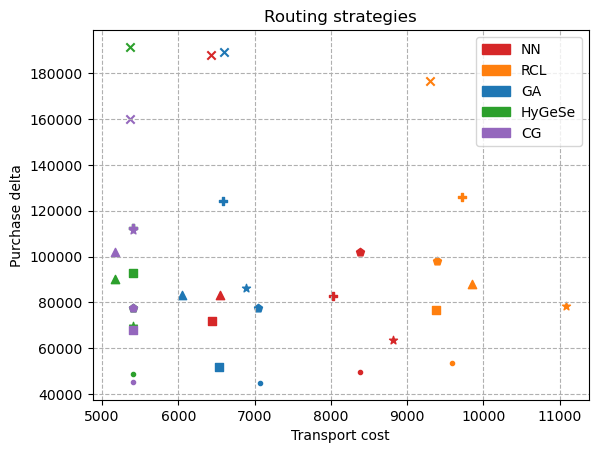

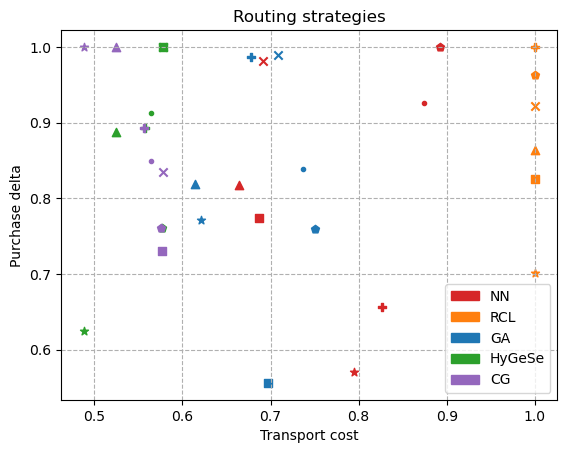

In [3]:
ep = 0
RoutingV.plot_solutions(inst_gen,routing_performance)
RoutingV.plot_solutions_standarized(inst_gen,routing_performance)

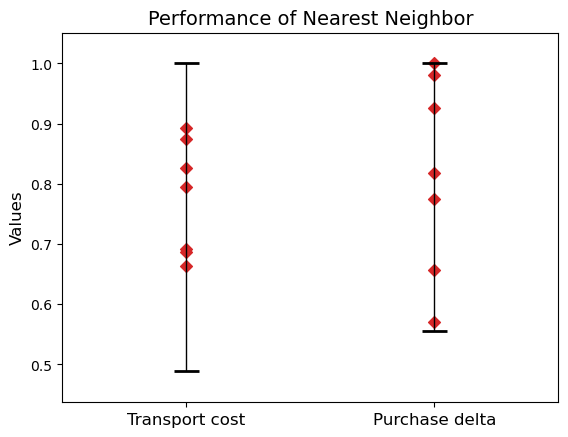

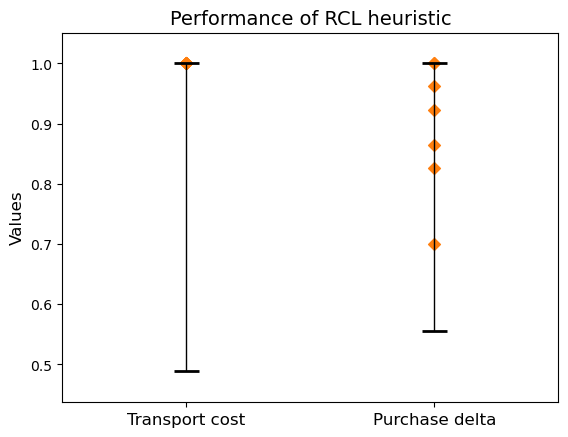

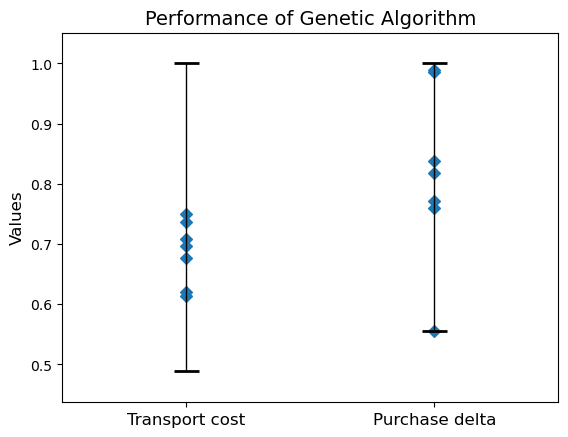

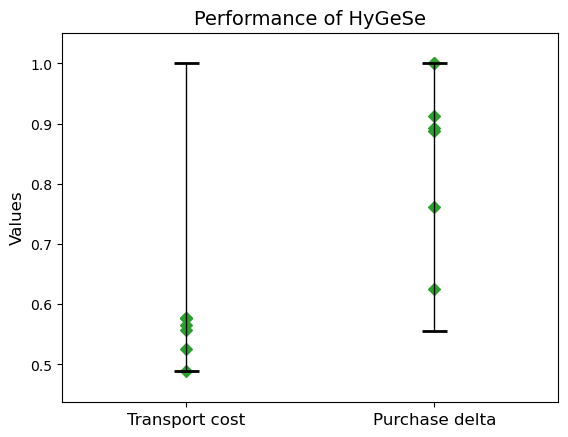

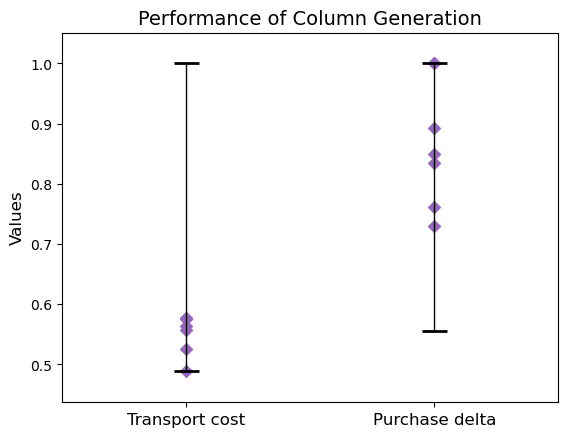

In [4]:
# strategy = 'GA' #'NN','RCL','GA','HyGeSe','CG'
for strategy in routing_performance[1].keys(): 
    RoutingV.plot_vertical_lines(inst_gen,routing_performance,strategy,name[strategy],colors[strategy])

# Product availability

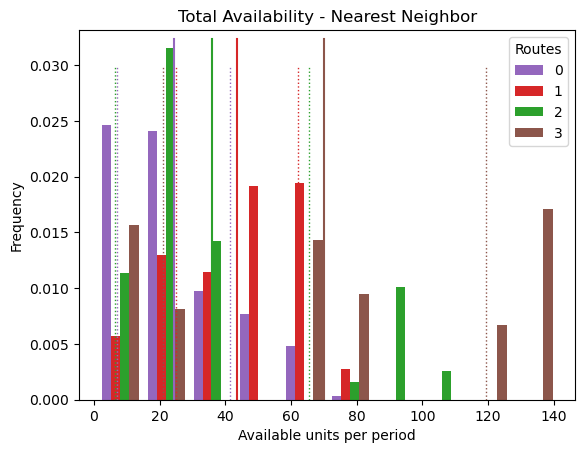

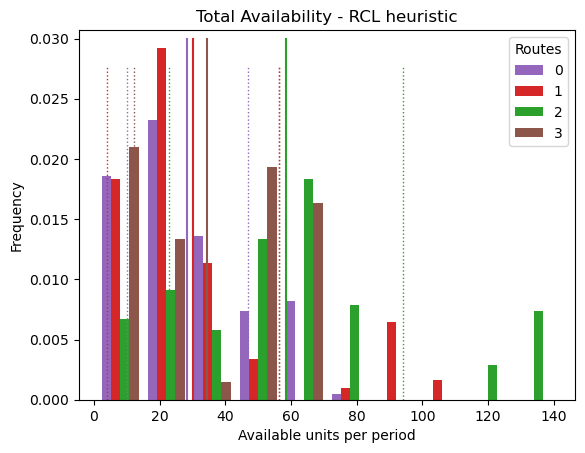

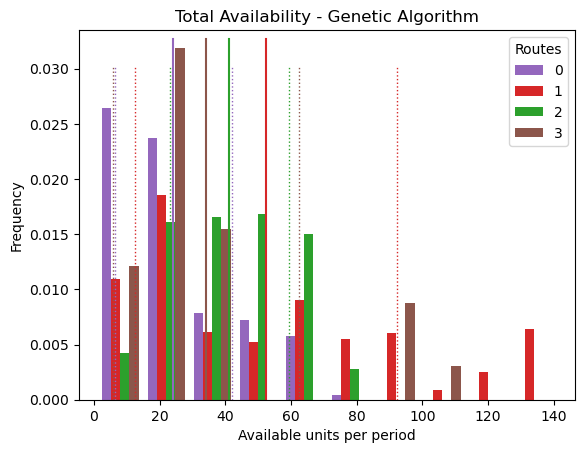

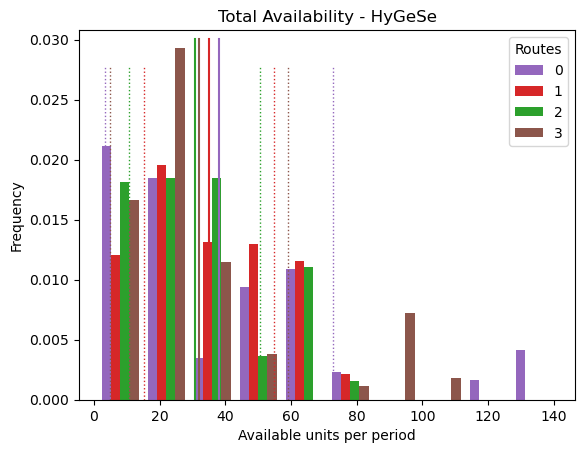

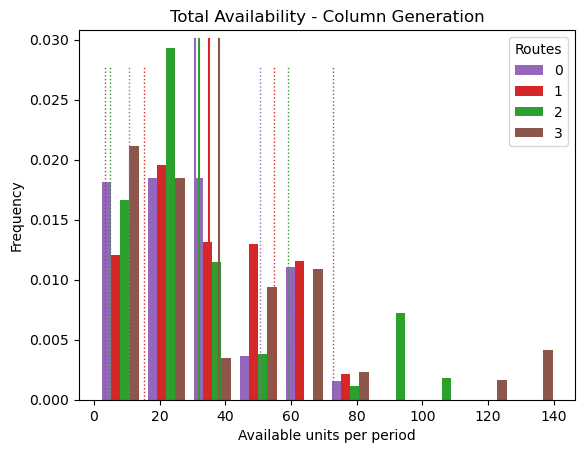

In [5]:
env.t = 0
for strategy in routing_performance[1].keys(): 
    RoutingV.routes_total_availability(routing_performance[1][strategy][0],inst_gen,env,False,name[strategy])

In [6]:
'''
    LAT LON MUNICIPIOS & FILTRO CUNDIBOY
'''
latlon = pd.read_excel('DIVIPOLA_Municipios_FIXED.xlsx')
latlon.dropna(inplace=True)
cundiboy = latlon[(latlon['DEPARTAMENTO'] == 'BOYACÁ') | (latlon['DEPARTAMENTO'] == 'CUNDINAMARCA') | (latlon["DEPARTAMENTO"] == "BOGOTÁ, D.C.")]
cundiboy['MUNICIPIO'] = cundiboy['MUNICIPIO'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
cundiboy['MUNI'] = cundiboy['MUNICIPIO'].copy()
cundiboy.set_index('MUNI', inplace=True)

'''
    PRODUCCION MUNICIPIOS
'''
DF = pd.read_csv("datos.csv", sep=";")
DF.rename(columns={'Municipio':'MUNICIPIO', 'Departamento':'DEPARTAMENTO', 'Producción':'PROD'}, inplace=True)

DF['MUNICIPIO'] = DF['MUNICIPIO'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
DF['MUNICIPIO'] = DF['MUNICIPIO'].str.upper()
DF['MUNI'] = DF['MUNICIPIO'].copy()
DF.set_index('MUNI', inplace=True)
DF
'''
    FILTRO POR PERCENTIL DE PRODUCCION
'''
cundiboy = cundiboy.join(DF,lsuffix='cundi', how='inner')
cundiboy = cundiboy[['LATITUD', 'LONGITUD', 'PROD', 'MUNICIPIO']]
percentile = cundiboy['PROD'].quantile(.95)
# cundiboy = cundiboy[ cundiboy['PROD']>percentile]

cundiboy = cundiboy.sample(n=inst_gen.M,random_state=3)
cundiboy


# Define the OSRM server URL
osrm_url = "http://router.project-osrm.org/route/v1/driving/"

# Initialize the map centered on the average coordinates
center_lat = cundiboy['LATITUD'].mean()
center_lon = cundiboy['LONGITUD'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=9)

# Function to calculate the route using OSRM
def calculate_route(source, destination):
    url = osrm_url + f"{source[1]},{source[0]};{destination[1]},{destination[0]}?overview=full&geometries=geojson"
    response = requests.get(url)
    data = json.loads(response.text)
    route = data['routes'][0]['geometry']['coordinates']
    distance = data['routes'][0]['distance']
    return route, distance

def fix(r):
  r2 = []
  for e in r:
    r2.append([e[1],e[0]])
  return r2

rutas, dist = {},{}
# Loop through pairs of municipalities to find direct trips and draw routes on the map
colors = ['red','orange','blue','green','purple']
translation = {'MOSQUERA':0}
for i,mun in enumerate(list(cundiboy.index)):
    translation[mun] = inst_gen.Suppliers[i]


strategy = 'CG'
for idx,route in enumerate(routing_performance[1][strategy][0]):
    tuples_route = [(route[i],route[i+1]) for i in range(len(route)-1)]
    for i in range(len(cundiboy)):
        lai = cundiboy.index[i]
        for j in range(len(cundiboy)):
            laj = cundiboy.index[j]
            if (translation[lai],translation[laj]) in tuples_route:
                source = (cundiboy.loc[lai, 'LATITUD'], cundiboy.loc[lai, 'LONGITUD'])
                destination = (cundiboy.loc[laj, 'LATITUD'], cundiboy.loc[laj, 'LONGITUD'])
                route, distance = calculate_route(source, destination)
                rutas[lai,laj] = route
                dist[lai,laj] = distance
                folium.PolyLine(fix(route), color=colors[idx], weight=4).add_to(m)

# Add markers for each municipality
for index, row in cundiboy.iterrows():
    folium.Marker([row['LATITUD'], row['LONGITUD']], tooltip=row['MUNICIPIO']).add_to(m)

# Display the map
m

/var/folders/m6/89fwm0dn5mjbdz4tkj6586bm0000gn/T/ipykernel_3273/3924367053.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cundiboy['MUNICIPIO'] = cundiboy['MUNICIPIO'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
/var/folders/m6/89fwm0dn5mjbdz4tkj6586bm0000gn/T/ipykernel_3273/3924367053.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cundiboy['MUNI'] = cundiboy['MUNICIPIO'].copy()


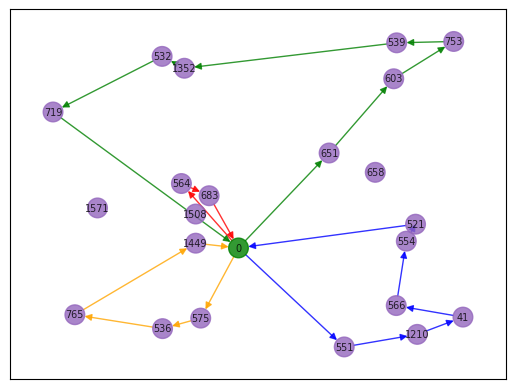

In [7]:
RoutingV.render_routes(inst_gen,routing_performance[1]['CG'][0])